<a href="https://colab.research.google.com/github/BetikuOluwatobi/commonlit-evaluate-student-summaries/blob/main/commonlit_kaggle_competition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!nvidia-smi

Sun Oct  8 16:10:22 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   65C    P8    11W /  70W |      0MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
!pip install spacy

In [ ]:
!python -m spacy download en_core_web_md

2023-10-08 16:10:32.234134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-08 16:10:33.219399: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
2023-10-08 16:10:34.570068: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-10-08 16:10:34.570557: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA n

In [ ]:
!pip install kaggle #Install the kaggle api if you don't have it installed

In [ ]:
!pip install --no-cache-dir transformers sentencepiece

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.7/7.7 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 61.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 295.0/295.0 kB 213.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.8/3.8 MB 73.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 99.2 MB/s eta 0:00:00


In [ ]:
!pip install autocorrect
!pip install pyspellchecker

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 622.8/622.8 kB 5.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for autocorrect: filename=autocorrect-2.6.1-py3-none-any.whl size=622363 sha256=0c2bf51a46e1a3d6a688318c8e9184abfe1867cfe8a91c71870bb084187062f8
  Stored in directory: /root/.cache/pip/wheels/b5/7b/6d/b76b29ce11ff8e2521c8c7dd0e5bfee4fb1789d76193124343
Successfully built autocorrect
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 9.7 MB/s eta 0:00:00


In [ ]:
import nltk
nltk.download('words')

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


True

In [ ]:
import pathlib, os, json
api_key = {"username":"oluwatobibetiku","key":"1a3294d30578dc489703e1a36a680dc5"} #Get your api key from kaggle settings
kaggle_path = pathlib.Path('/root/.kaggle') #specify the root directory using pathlib
os.makedirs(kaggle_path,exist_ok=True)
with open(kaggle_path/'kaggle.json','w') as handl:
  json.dump(api_key,handl) #dump a kaggle.json file containi g your credentials in the root directory, this is essential for the kaggle api

os.chmod(kaggle_path/'kaggle.json', 600)

In [ ]:
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()

In [ ]:
api.competition_download_file('commonlit-evaluate-student-summaries','summaries_train.csv','./')
api.competition_download_file('commonlit-evaluate-student-summaries','prompts_train.csv','./')

100%|██████████| 1.04M/1.04M [00:00<00:00, 74.1MB/s]

100%|██████████| 15.8k/15.8k [00:00<00:00, 7.93MB/s]

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.model_selection import train_test_split
import tensorflow as tf
import torch
import spacy
from tqdm import tqdm
from spacy.tokens import Doc
from nltk.tokenize import word_tokenize
from spellchecker import SpellChecker
import re
from autocorrect import Speller
from string import punctuation as punc
from collections import defaultdict
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from textblob import TextBlob
import math
from collections import Counter
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from nltk.corpus import words
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from tensorflow.keras import backend as K
from transformers import AutoTokenizer,TFAutoModel, pipeline
from scipy.special import softmax
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from scipy.stats import skew, kurtosis


class NLTKTokenizer(object):
    def __init__(self, vocab):
        self.vocab = vocab

    def __call__(self, text):
        # Tokenize the text using nltk's word_tokenize
        words = word_tokenize(text)

        # Convert the list of words to a spaCy Doc object
        return Doc(self.vocab, words=words)


nlp = spacy.load("en_core_web_md")
# Set spaCy's tokenizer to the custom tokenizer
nlp.tokenizer = NLTKTokenizer(nlp.vocab)
checker = SpellChecker()
speller = Speller(lang='en')
english = set(words.words())

In [ ]:
summary_df = pd.read_csv('summaries_train.csv.zip',compression='zip')
prompt_df = pd.read_csv('prompts_train.csv')

In [ ]:
summary_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7165 entries, 0 to 7164
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   student_id  7165 non-null   object 
 1   prompt_id   7165 non-null   object 
 2   text        7165 non-null   object 
 3   content     7165 non-null   float64
 4   wording     7165 non-null   float64
dtypes: float64(2), object(3)
memory usage: 280.0+ KB


In [ ]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (7,5)

In [ ]:
# d_99 = np.argmax(cumsum >= 0.99) + 1
# d_95 = np.argmax(cumsum >= 0.95) + 1

In [ ]:
# d_99

In [ ]:
#@title plot for comparing matplotlib pyplot
def get_plot(d_lower,d_higher,cumsum):
    fig, axis = plt.subplots()
    axis.step(range(len(cumsum)),cumsum, where='mid', c='b',linestyle='--',label='Explained Ration')
    axis.vlines(d_higher, 0, cumsum[d_higher], colors='orange', linestyles='--',label=f'{d_higher} components')
    axis.vlines(d_lower, 0, cumsum[d_lower],colors='red', linestyles='--', label=f'{d_lower} components')
    axis.hlines(cumsum[d_higher], -200, 5000, colors='orange', linestyles='--', label=f'{cumsum[d_higher]:.2f} cumsum')
    axis.hlines(cumsum[d_lower], -200, 5000,colors='red', linestyles='--', label=f'{cumsum[d_lower]:.2f} cumsum')
    axis.set_xlim([-200, 5000])
    axis.set_xlabel('Principal Components Index')
    axis.set_ylabel('Explained Variance Ratio')
    axis.grid(True)
    plt.legend(loc='best')
    plt.show()

In [ ]:
# get_plot(d_lower=d_95,d_higher=d_99,cumsum=cumsum)

In [ ]:
SAVED_MODEL_DIR = 'microsoft/deberta-v3-small'
tokenizer = AutoTokenizer.from_pretrained(SAVED_MODEL_DIR,use_fast=False)
# model = DebertaModel.from_pretrained(SAVED_MODEL_DIR,ignore_mismatched_sizes=True)
model = TFAutoModel.from_pretrained(SAVED_MODEL_DIR, from_pt=True)


# fe = pipeline('feature-extraction', tokenizer=tokenizer,model=model,torch_dtype=torch.float16,device=0)

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDebertaV2Model: ['lm_predictions.lm_head.bias', 'lm_predictions.lm_head.dense.weight', 'mask_predictions.dense.weight', 'lm_predictions.lm_head.dense.bias', 'mask_predictions.dense.bias', 'mask_predictions.classifier.weight', 'lm_predictions.lm_head.LayerNorm.weight', 'mask_predictions.classifier.bias', 'deberta.embeddings.position_embeddings.weight', 'mask_predictions.LayerNorm.weight', 'mask_predictions.LayerNorm.bias', 'lm_predictions.lm_head.LayerNorm.bias']
- This IS expected if you are initializing TFDebertaV2Model from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDebertaV2Model from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification 

In [ ]:
def extract_lemmas(text):
    doc = nlp(text)
    lemmas = []

    for token in doc:
        if not token.is_stop:
            lemmas.append(token.lemma_.lower())
    return ' '.join(lemmas)


def count_punc(text):
    return len([p for p in text if p in punc])

# Overlap Score

def tree_depth_from_token(token):
    """Calculate the depth of a subtree rooted at a token."""
    if not list(token.children):
        return 1
    else:
        return 1 + max(tree_depth_from_token(child) for child in token.children)

def average_dependency_tree_depth(doc):
    """Compute the average depth of the dependency tree."""
    root_tokens = [tok for tok in doc if tok.dep_ == 'ROOT']
    if not root_tokens:
        return 0
    depths = [tree_depth_from_token(token) for token in root_tokens]
    return sum(depths) / len(depths)

def process_text(doc):
    # Using collections.Counter to count the occurrences efficiently
    pos_counts = Counter([token.pos_ for token in doc if not token.is_stop])

    # Extract counts directly using the dictionary
    num_nouns = pos_counts.get("NOUN", 0)
    num_verbs = pos_counts.get("VERB", 0)
    num_adverbs = pos_counts.get("ADV", 0)
    stops = sum(1 for token in doc if token.is_stop)

    return stops, num_nouns, num_verbs, num_adverbs


def syllable_count(word):
    word = word.lower()
    vowels = set("aeiouy")
    count = sum(1 for idx, char in enumerate(word)
                if char in vowels and (idx == 0 or word[idx-1] not in vowels))

    # Decrease count if word ends with an 'e' but is not preceded by a vowel
    if word.endswith("e") and (len(word) == 1 or word[-2] not in vowels):
        count -= 1

    # Ensure at least one syllable
    count = max(1, count)

    return count

def extract_features(row, docs, context_docs):
    idx = row.name
    doc = docs[idx]
    context = context_docs[idx]

    # Word Tokenize
    tokens = [tok.text.lower() for tok in doc]
    context_tokens = [tok.text.lower() for tok in context]

    # Capital Error
    capital_error = sum(1 for sent in doc.sents if not sent.text[0].isupper())

    # 1. Length of the summary
    length = len(tokens)

    # 2. Number of unique words
    unique_words = len(set(tokens))

    #3. counter
    total_tokens = len(tokens) if length > 0 else 1
    word_counts = Counter(tokens)
    once = sum(1 for word, count in word_counts.items() if count == 1)
    twice = sum(1 for word, count in word_counts.items() if count == 2)

    # 4. Named entities
    entities = set(ent.text.lower() for ent in doc.ents)
    context_entities = set(ent.text.lower() for ent in context.ents)
    num_entities = len(entities)
    context_num_entities = len(context_entities)

    # Calculate the overlap between the two sets
    overlap_entities = context_entities.intersection(entities)

    # Calculate the coverage score: (number of overlapping entities) / (number of entities in original text)
    coverage_score = len(overlap_entities) / len(context_entities) if len(context_entities) > 0 else 0
    num_overlap_entities = len(overlap_entities)

    named_entity_ratio = float(num_entities/total_tokens)
    context_entity_ratio = float(context_num_entities/len(context_tokens))

    # 5. Average word length
    avg_word_len = round(sum([len(token) for token in tokens])/total_tokens, ndigits=4)
    context_avg_word_len = round(sum([len(token) for token in context_tokens])/len(context_tokens), ndigits=4)

    # 6. Summary Polarity
    text_blob = TextBlob(row['text'])
    context_blob = TextBlob(row['prompt_text'])
    sentiment_polarity = text_blob.sentiment.polarity
    subjectivity = text_blob.subjectivity
    context_subjectivity = context_blob.subjectivity
    context_polarity = context_blob.sentiment.polarity
    error = sum(1 for token in tokens if token not in english)
    error_ratio = error/total_tokens


    # 7. Stopwords verbs and nouns
    stops,num_nouns, num_verbs, num_adverbs = process_text(doc)
    context_stops,context_nouns, context_verbs, context_adverbs = process_text(context)

    # 8. Numerical entities
    num_numerical_entities = len([ent for ent in doc.ents if ent.label_ == "CARDINAL"])


    # 9. Sentece count
    sentences = [sent.text for sent in doc.sents]
    sentence = len(sentences) if len(sentences) > 0 else 1
    avg_sentence = float(sentence / total_tokens)
    avg_unique_sentence = float(sentence /unique_words) if unique_words > 0 else 0.0

    avg_sentence_length = sum(len(sent) for sent in sentences) / sentence
    max_sentence_length = max(len(sent) for sent in sentences)
    min_sentence_length = min(len(sent) for sent in sentences)
    std_sentence_length = (sum((len(sent) - avg_sentence_length)**2 for sent in sentences) / sentence)**0.5

    # 10 Tree Depth
    average_tree_depth = average_dependency_tree_depth(doc)
    prob_word = [count/total_tokens for word, count in word_counts.items()]
    results = {
        "nsubj": 0,
        "amod": 0,
        "advmod": 0,
        "xcomp": 0,
        "acomp": 0,
        "past": 0,
        "present": 0
    }

    num_syllables = 0

    summary_punc = 0
    for token in doc:
        if "VERB" == token.pos_:
            if "VBD" == token.tag_ or "VBN" == token.tag_:
                results["past"] += 1
            elif token.tag_ in {"VBG", "VBP", "VBZ"}:
                results["present"] += 1
        # Check if the token's dependency is one of the desired dependencies
        if token.dep_ in results:
            results[token.dep_] += 1

        if token.is_alpha:
            num_syllables += syllable_count(token.text.lower())

        if token.is_punct:
            summary_punc += 0

    # Unigram similarity
    summary_set = set(tokens) if length > 0 else set()
    context_set = set(context_tokens) if len(context_tokens) > 0 else set()
    intersection = len(context_set.intersection(summary_set))
    difference = len(context_set.difference(summary_set))
    union = len(context_set.union(summary_set))
    precision = float(intersection /unique_words) if unique_words > 0 else 0.0
    recall = float(intersection / len(context_set)) if len(context_set) > 0 else 0.0
    jaccard_similarity = float(intersection/union) if union > 0 else 0.0
    overlap_score = intersection/float(min(len(context_set), len(summary_set)) + 1e-11)
    f1_score = float(2 * ((precision * recall)/(precision + recall + 1e-11)))


    # Bigram Similarity
    answer_bigrams = set(list(ngrams(tokens, 2))) if length > 1 else set()
    context_bigrams = set(list(ngrams(context_tokens, 2))) if len(context_tokens) > 1 else set()
    intersection_bigram = len(answer_bigrams.intersection(context_bigrams))
    union_bigram = len(answer_bigrams.union(context_bigrams))
    precision_bigram = intersection_bigram /len(answer_bigrams) if len(answer_bigrams) > 0 else 0.0
    recall_bigram = intersection_bigram / len(context_bigrams) if len(context_bigrams) > 0 else 0.0
    jaccard_bigram = intersection_bigram/union_bigram if union_bigram > 0 else 0.0
    bigram_overlap = intersection_bigram/float(min(len(context_bigrams), len(answer_bigrams)) + 1e-11)
    f1_bigram = 2 * ((precision_bigram * recall_bigram)/(precision_bigram + recall_bigram + 1e-11))

    # Trigram Similarity
    answer_trigrams = set(list(ngrams(tokens, 3))) if length > 1 else set()
    context_trigrams = set(list(ngrams(context_tokens, 3))) if len(context_tokens) > 1 else set()
    intersection_trigram = len(answer_trigrams.intersection(context_trigrams))
    union_trigram = len(answer_trigrams.union(context_trigrams))
    precision_trigram = intersection_trigram / len(answer_trigrams) if len(answer_trigrams) > 0 else 0.0
    recall_trigram = intersection_trigram / len(context_trigrams) if len(context_trigrams) > 0 else 0.0
    jaccard_trigram = intersection_trigram/union_trigram if union_trigram > 0 else 0.0
    trigram_overlap = intersection_trigram/float(min(len(context_trigrams), len(answer_trigrams)) + 1e-11)
    f1_trigram = 2 * ((precision_trigram * recall_trigram)/(precision_trigram + recall_trigram + 1e-11))

    # Readability
    ASL = float(total_tokens / sentence)
    ASW = float(num_syllables / total_tokens)

    flesch_reading_ease = 206.835 - (1.015 * ASL) - (84.6 * ASW)
    flesch_kincaid = (0.39 * ASL) + (11.8 * ASW) - 15.59

    # Automated Reading Index
    characters = len("".join(tokens))
    summary_ari = 4.71 * (characters / total_tokens) + 0.5 * (total_tokens / sentence) - 21.43

    # Coleman-Liau Index Readability
    # Where: L is the average number of letters per 100 words, S is the average number of sentences per 100 words
    L = (characters / total_tokens) * 100
    S = (sentence / total_tokens) * 100
    coleman_index = (0.0588 * L) - (0.296 * S) - 15.8

    # Mispelt
    mis_tokens = [token for token in checker.unknown(tokens) if token.isalpha()]
    mispell_ratio = len(mis_tokens)/total_tokens
    quotes = len(re.findall(r'"(.*?)"|\'(.*?)\'|“(.*?)”|‘(.*?)’|«(.*?)»|‹(.*?)›', row['text']))

    source_vector = context.vector
    answer_vector = doc.vector

    embedding_similarity, euclidean, pearson = compute_similarity_score(source_vector, answer_vector)


    # Organizing features in a dictionary
    features = {
        'length': length,
        'num_chars': len(row['text']),
        "mispelt_tokens": len(mis_tokens),
        "capital_error": capital_error,
        "mispell_ratio": mispell_ratio,
        "quotes": quotes,
        "intersection_bigram": intersection_bigram,
        "union_bigram": union_bigram,
        "jaccard_bigram": jaccard_bigram,
        'recall_bigram': recall_bigram,
        "precision_bigram": precision_bigram,
        "f1_bigram": f1_bigram,
        'bigram_overlap': bigram_overlap,
        'sentence': sentence,
        'avg_sentence_length': avg_sentence_length,
        'max_sentence_length': max_sentence_length,
        'min_sentence_length':min_sentence_length,
        "std_sentence_length": std_sentence_length,
        "avg_sentence": avg_sentence,
        'avg_unique_sentence':avg_unique_sentence,
        "context_avg_word_len": context_avg_word_len,
        "error": error,
        'error_ratio': error_ratio,
        'unique_words': unique_words,
        'num_entities': num_entities,
        "context_num_entities": context_num_entities,
        'coverage_score': coverage_score,
        'num_overlap_entities': num_overlap_entities,
        'avg_word_len': avg_word_len,
        'intersection_trigram': intersection_trigram,
        'union_trigram': union_trigram,
        'recall_trigram': recall_trigram,
        'precision_trigram': precision_trigram,
        'jaccard_trigram': jaccard_trigram,
        'trigram_overlap': trigram_overlap,
        'f1_trigram': f1_trigram,
        "stops": stops,
        "num_nouns": num_nouns,
        "num_verbs": num_verbs,
        "num_adverbs": num_adverbs,
        "context_nouns": context_nouns,
        "context_stops": context_stops,
        'context_verbs': context_verbs,
        'context_adverbs': context_adverbs,
        "num_numerical_entities": num_numerical_entities,
        "sentiment_polarity": sentiment_polarity,
        'context_polarity': context_polarity,
        "nsubj": results['nsubj'],
        "amod": results['amod'],
        "advmod": results['advmod'],
        "xcomp": results['xcomp'],
        "acomp": results['acomp'],
        "past": results["past"],
        "present": results["present"],
        "average_dependency_tree_depth": average_tree_depth,
        "TTR": unique_words / (total_tokens + 1e-8),
        "RTTR": unique_words / (math.sqrt(total_tokens) + 1e-8),
        "CTTR": unique_words / (math.sqrt(total_tokens / 2) + 1e-8),
        # MATTR would require a window-based approach and is thus more involved
        "Herdan's C": math.log(unique_words) / (math.log(total_tokens) + 1e-8),
        "Dugast's U": math.log(total_tokens)**2 / ((math.log(total_tokens) - math.log(unique_words)) + 1e-8),
        "Honoré's H": 100 * math.log(total_tokens) / (1 - once/(unique_words + 1e-8)),
        "Entropy": -sum(p * math.log(p) for p in prob_word),
        "Sichel’s S": twice,
        'named_entity_ratio': named_entity_ratio,
        'context_entity_ratio': context_entity_ratio,
        'flesch_reading_ease': flesch_reading_ease,
        'flesch_kincaid': flesch_kincaid,
        'summary_ari':summary_ari,
        'coleman_index': coleman_index,
        "Simpson’s D": sum((count/total_tokens)**2 for count in word_counts.values()),
        'intersection': intersection,
        "subjectivity": subjectivity,
        "context_subjectivity": context_subjectivity,
        'difference': difference,
        'union': union,
        'overlap_score': overlap_score,
        'recall': recall,
        'precision': precision,
        'f1_score': f1_score,
        'jaccard_similarity': jaccard_similarity,
        'embedding_similarity': embedding_similarity,
        'euclidean': euclidean,
        'pearson': pearson,
        'summary_punc': summary_punc,
    }

    return features

def compute_similarity_score(source_vector, answer_vector):
    embedding_similarity = cosine_similarity([source_vector], [answer_vector])[0][0]
    euclidean = euclidean_distances([source_vector], [answer_vector])[0][0]
    pearson = np.corrcoef(source_vector.ravel(), answer_vector.ravel())[0, 1]

    return embedding_similarity, euclidean, pearson

def compute_statistical_measures(embedding):
    negatives_count = np.sum(embedding < 0, axis=1)
    negatives_count_ratio = negatives_count/768
    pos = 768 - negatives_count
    pos_ratio = pos/768
    neg_pos_ratio = negatives_count/pos
    embed_sum = np.sum(embedding, axis=1)
    embed_mean = np.mean(embedding, axis=1)
    embed_var = np.var(embedding, axis=1)
    embed_std = np.std(embedding, axis=1)
    quantile_1 = np.quantile(embedding,0.25,axis=1)
    quantile_2 = np.quantile(embedding,0.5,axis=1)
    quantile_3 = np.quantile(embedding,0.75,axis=1)
    quantile_4 = np.quantile(embedding,1,axis=1)
    embed_range = np.max(embedding,axis=1) - np.min(embedding,axis=1)
    p2p = np.ptp(embedding, axis=1)
    skewed_bag = skew(embedding, axis=1)
    kurtosis_bag = kurtosis(embedding, axis=1)
    output =  np.asarray([embed_range,embed_sum, embed_mean, embed_var, embed_std,
                          pos, pos_ratio, negatives_count,negatives_count_ratio,
                          neg_pos_ratio, quantile_1,quantile_2, quantile_3,
                          quantile_4,p2p,skewed_bag,kurtosis_bag],dtype=np.float32).T
    return output

def compute_tensor(texts, max_len=128):
    outputs = tokenizer(texts,  max_length=max_len,padding='max_length',
                    truncation=True,return_tensors='tf')
    tensor = model(**outputs)['last_hidden_state']
    return tensor
def compute_scores(batch_texts,max_len):
    tensor = compute_tensor(batch_texts, max_len)
    embed_mean = tf.reduce_mean(tensor, axis=1).cpu().numpy()
    embed_max = tf.reduce_max(tensor, axis=1).cpu().numpy()
    embed_first = tensor[:,0,:].cpu().numpy()

    features_batch = np.hstack((embed_mean, embed_max, embed_first))
    return features_batch

In [ ]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [ ]:
train_df = summary_df.merge(right=prompt_df,how='inner', on='prompt_id')

In [ ]:
# @title run bert
import time

BATCH_SIZE = 12

start = time.time()
scores = []
num_samples = len(train_df)
for start_idx in tqdm(range(0, num_samples, BATCH_SIZE), desc="processing feature extraction"):
    end_idx = min(start_idx + BATCH_SIZE, num_samples)
    batch_texts = train_df.iloc[start_idx:end_idx]['text'].apply(speller).tolist()

    with tf.device('/GPU:0'):
        scores_batch = compute_scores(batch_texts, max_len=256)
        scores.extend(scores_batch)

        K.clear_session()

bert_features = np.asarray(scores, dtype=np.float32)
stats_mean = compute_statistical_measures(bert_features[:,:768])
stats_max = compute_statistical_measures(bert_features[:,768:1536])
stats_first = compute_statistical_measures(bert_features[:,1536:])

bert_bag = np.hstack((bert_features[:,:768],stats_mean,stats_max,stats_first))
end = time.time()
ellapsed_time = end - start
print(f'time ellapsed is: {ellapsed_time:.2f}ms')

processing feature extraction:   0%|          | 0/598 [00:00<?, ?it/s]WARNING:tensorflow:From <ipython-input-20-c2aef38e6591>:357: _EagerTensorBase.cpu (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.identity with explicit device placement instead.
processing feature extraction: 100%|██████████| 598/598 [13:25<00:00,  1.35s/it]


time ellapsed is: 807.79ms


###### embed_range,embed_sum, embed_mean, embed_var, embed_std,pos, pos_ratio, negatives_count,negatives_count_ratio,neg_pos_ratio, quantile_1,quantile_2, quantile_3,quantile_4,p2p,skewed_bag,kurtosis_bag

In [ ]:
from scipy import stats
sample = stats_max[:,5] #neg_ratio
# sample = np.log2(np.log2(sample)) ** 2

In [ ]:
np.sum(np.isnan(sample))

0

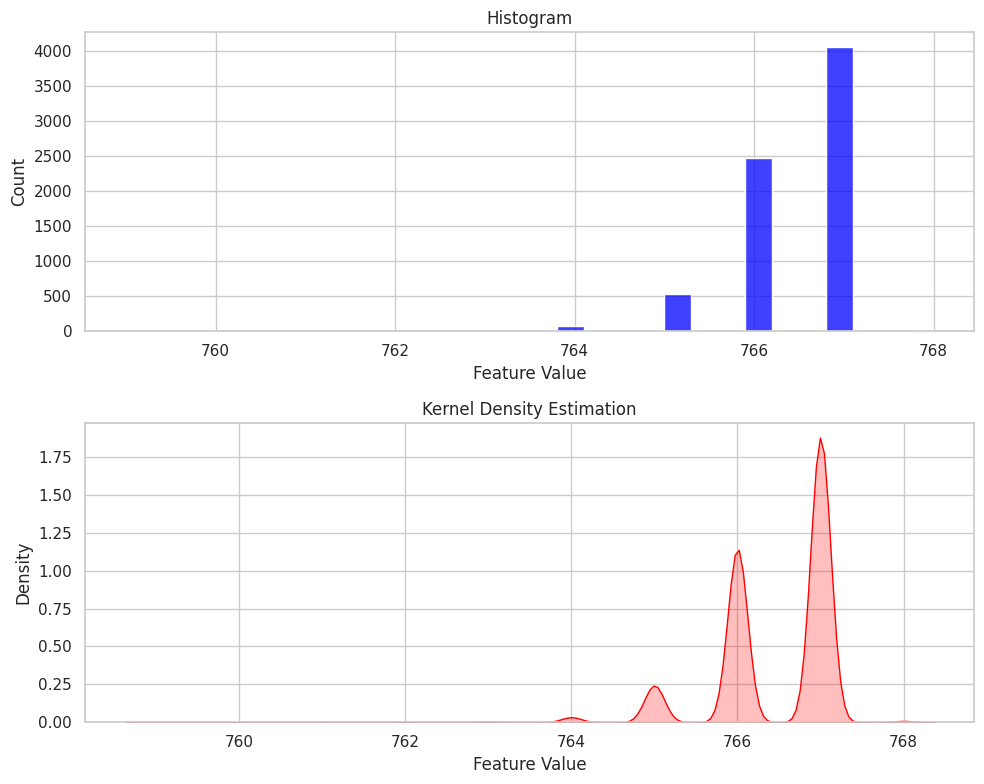

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Generate random data for demonstration

# Set style
sns.set(style="whitegrid")

# Create a figure and a set of subplots
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(10, 8))

# Plot histogram
sns.histplot(sample, kde=False, bins=30, ax=ax[0], color='blue')
ax[0].set_title('Histogram')
ax[0].set_xlabel('Feature Value')
ax[0].set_ylabel('Count')

# Plot KDE (Kernel Density Estimation)
sns.kdeplot(sample, ax=ax[1], color='red', fill=True)
ax[1].set_title('Kernel Density Estimation')
ax[1].set_xlabel('Feature Value')
ax[1].set_ylabel('Density')

# Display plots
plt.tight_layout()
plt.show()

In [ ]:
def preprocess_data(summary_df, prompt_df, BATCH_SIZE=8, max_len=256):
    train_df = summary_df.merge(right=prompt_df, how='inner', on='prompt_id')

    print('processing text embeddings......')
    docs = list(nlp.pipe(train_df['text']))
    context_docs = list(nlp.pipe(train_df['prompt_text']))

    # processing lemmas
    print('extracting features.....')
    drop_cols = [
                "mispelt_tokens","mispell_ratio",'error_ratio',
                'context_nouns','context_entity_ratio',
                'context_verbs', 'context_adverbs','context_subjectivity'
    ]
    data_cols = ['context_subjectivity', 'difference', 'recall',
        'union','union_trigram', 'recall_trigram',
        'union_bigram', 'recall_bigram',
        'context_nouns','context_entity_ratio',
        'context_verbs', 'context_adverbs']

    data = pd.DataFrame(train_df.apply(extract_features, args=(docs, context_docs), axis=1).tolist())
    content_data = data.drop(drop_cols, axis=1)
    data = data.drop(data_cols, axis=1)

    print('processing features.....')
    # Process other columns
    scores = []
    num_samples = len(train_df)
    for start_idx in tqdm(range(0, num_samples, BATCH_SIZE), desc="processing feature extraction"):
        end_idx = min(start_idx + BATCH_SIZE, num_samples)
        batch_texts = train_df.iloc[start_idx:end_idx]['text'].apply(speller).tolist()

        with tf.device('/GPU:0'):
            scores_batch = compute_scores(batch_texts, max_len=max_len)
            scores.extend(scores_batch)

            K.clear_session()

    bert_features = np.asarray(scores, dtype=np.float32)
    stats_mean = compute_statistical_measures(bert_features[:,:768])
    stats_max = compute_statistical_measures(bert_features[:,768:1536])
    stats_first = compute_statistical_measures(bert_features[:,1536:])

    bags = np.hstack((bert_features[:,:768],stats_mean,stats_max,stats_first,
                             content_data.values, train_df[['content','wording']].values))

    print('collecting outputs.........')
    student_ids = train_df['student_id'].values

    return bags, student_ids

In [ ]:
from nltk.corpus import words
english = set(words.words())

In [ ]:
import time

start_time = time.time()

stacked_bag, student_ids = preprocess_data(summary_df,prompt_df,BATCH_SIZE=8,
                                                        max_len=256)

end_time = time.time()
elapsed_time = end_time - start_time

print(f"Preprocessed function executed in: {elapsed_time:.2f} seconds")

processing text embeddings......
extracting features.....
processing features.....


processing feature extraction:   0%|          | 0/896 [00:00<?, ?it/s]WARNING:tensorflow:From <ipython-input-20-77dad51e6181>:357: _EagerTensorBase.cpu (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.identity with explicit device placement instead.
processing feature extraction: 100%|██████████| 896/896 [17:32<00:00,  1.17s/it]


collecting outputs.........
Preprocessed function executed in: 2057.86 seconds


In [ ]:
X_train,X_test,y_train,y_test = train_test_split(stacked_bag[:,:-2] ,stacked_bag[:,-2:],test_size=0.1,shuffle=True,random_state=11)

In [ ]:
X_train.shape, y_train.shape

((6448, 895), (6448, 2))

In [ ]:
def mcrmse(y_true, y_pred):
    return np.mean(np.sqrt(np.mean((y_true - y_pred)**2, axis=0)))

In [ ]:
from sklearn.model_selection import KFold
import lightgbm as lgb
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.multioutput import MultiOutputRegressor
start_time = time.time()

best_params = {
    'learning_rate': 0.01,
    'n_estimators': 500,
    'max_depth': 11,
    'subsample': 0.6,
    'colsample_bytree': 0.6,
#     'objective': 'reg:squarederror'
}

best_models = []

score = []
kfold = KFold(n_splits=20, shuffle=True, random_state=64)
for train_idx, test_idx in tqdm(kfold.split(X_train, y_train), desc='training model'):
    X, y = X_train[train_idx], y_train[train_idx]
    test,test_y = X_train[test_idx], y_train[test_idx]
    pipeline = MultiOutputRegressor(make_pipeline(
        MinMaxScaler(feature_range=(-1,10)),
        lgb.LGBMRegressor(**best_params, random_state=64)),
        n_jobs=-1
        )
    pipeline.fit(X, y)
    score.append(mcrmse(test_y,pipeline.predict(test)))
    best_models.append(pipeline)

end_time = time.time()
elapsed_time = end_time - start_time
print(f"Preprocessed function executed in: {elapsed_time:.2f} seconds")
print(f'Mean Score: {np.mean(score):.2f}')

training model: 20it [29:39, 88.98s/it]

Preprocessed function executed in: 1779.61 seconds
Mean Score: 0.47


In [ ]:
best_scores = []
for i in range(len(best_models)):
    best_model = best_models[i]
    y_preds = best_model.predict(X_test)
    best_scores.append(mcrmse(y_test,y_preds))
print(f'Mean Score: {np.mean(best_scores):.2f}')

Mean Score: 0.46


In [ ]:
best_model_idx = np.argmin(best_scores)
best_model = best_models[best_model_idx]
y_preds = best_model.predict(X_test)
mcrmse(y_test,y_preds)

0.45698224691776046

0.51, 0.50, 0.4957858841087569 / 0.5045887382622728

In [ ]:
# import tensorflow_decision_forests as tfds
import tensorflow as tf
from tensorflow.keras.layers import Dense,LSTM, Input, Embedding
from tensorflow.keras.models import Sequential

In [ ]:
tf.keras.backend.clear_session()

In [ ]:
def expand_dims(features, labels):
    features = tf.expand_dims(features, axis=0)
    features = tf.cast(features, tf.float32, name='input_features')
    labels = tf.cast(labels, tf.float32, name='labels')
    return {'input_features':features}, labels

In [ ]:
f_shape = X_train.shape[1]
batch_size = 64

dataset = tf.data.Dataset.from_tensor_slices((X_train,y_train))
dataset = dataset.map(expand_dims,num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
dataset = dataset.cache()
dataset = dataset.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(X_train.shape[0])
dataset = dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
dataset.element_spec

({'input_features': TensorSpec(shape=(64, 1, 834), dtype=tf.float32, name=None)},
 TensorSpec(shape=(64, 2), dtype=tf.float32, name=None))

In [ ]:
def build_model():
    model = Sequential([
        Input(shape=(None,f_shape),batch_size=batch_size,name='input_features',dtype=tf.float32),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(256,activation='relu',return_sequences=True)),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,activation='sigmoid',return_sequences=True)),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128,activation='relu')),
        tf.keras.layers.Dropout(0.1),
        Dense(64,activation='sigmoid'),
        Dense(32, activation='relu'),
        Dense(2, activation='tanh')
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-4),
                 loss=tf.keras.losses.MeanSquaredError(), metrics=['mse'])
    return model

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_dataset = val_dataset.map(expand_dims,num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(batch_size=batch_size, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE).shuffle(100000)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
dl_model = build_model()
history = dl_model.fit(dataset,validation_data=val_dataset,batch_size=batch_size,epochs=100,callbacks=[early_stopping])

Epoch 1/100
100/100 [==============================] - 26s 45ms/step - loss: 1.0336 - mse: 1.0336 - val_loss: 0.6512 - val_mse: 0.6512
Epoch 2/100
100/100 [==============================] - 3s 25ms/step - loss: 0.6400 - mse: 0.6400 - val_loss: 0.5703 - val_mse: 0.5703
Epoch 3/100
100/100 [==============================] - 3s 27ms/step - loss: 0.6159 - mse: 0.6159 - val_loss: 0.5626 - val_mse: 0.5626
Epoch 4/100
100/100 [==============================] - 3s 33ms/step - loss: 0.6117 - mse: 0.6117 - val_loss: 0.6060 - val_mse: 0.6060
Epoch 5/100
100/100 [==============================] - 1s 12ms/step - loss: 0.6028 - mse: 0.6028 - val_loss: 0.5677 - val_mse: 0.5677
Epoch 6/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5975 - mse: 0.5975 - val_loss: 0.5649 - val_mse: 0.5649
Epoch 7/100
100/100 [==============================] - 1s 11ms/step - loss: 0.5956 - mse: 0.5956 - val_loss: 0.5612 - val_mse: 0.5612
Epoch 8/100
100/100 [==============================] - 1s 11m

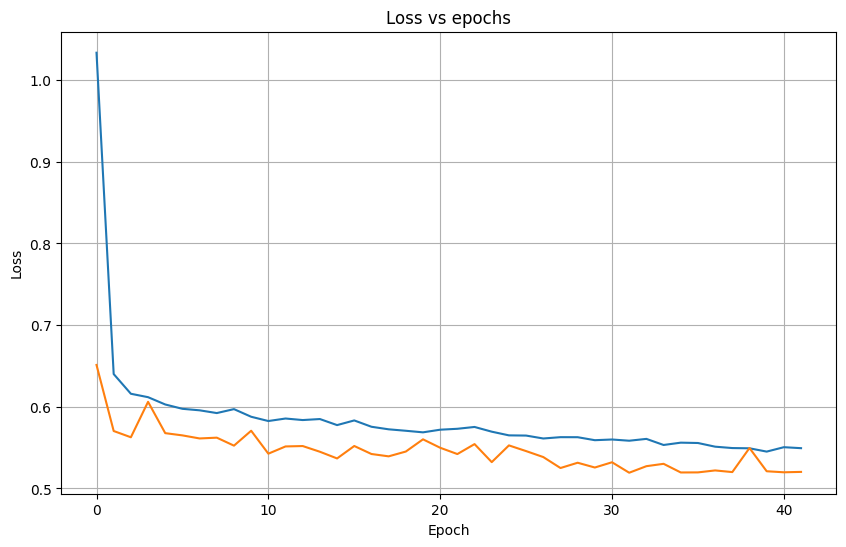

In [ ]:
import matplotlib.pyplot as plt

# Extract learning rates and losses from the training history
epochs = range(len(history.history['loss']))
losses = history.history['loss']
val_losses = history.history['val_loss']

plt.figure(figsize=(10, 6))
plt.plot(epochs, losses)
plt.plot(epochs, val_losses)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss vs epochs')
plt.grid(True)
plt.show()

In [ ]:
val_dataset = tf.data.Dataset.from_tensor_slices((X_test,y_test))
val_dataset = val_dataset.map(expand_dims,num_parallel_calls=tf.data.AUTOTUNE,deterministic=False)
val_dataset = val_dataset.cache()
val_dataset = val_dataset.batch(batch_size=1, drop_remainder=True, num_parallel_calls=tf.data.AUTOTUNE)
val_dataset = val_dataset.prefetch(tf.data.AUTOTUNE)
preds = dl_model.predict(val_dataset)

717/717 [==============================] - 3s 3ms/step


In [ ]:
def mcrmse(y_true, y_pred):
    return np.mean(np.sqrt(np.mean((y_true - y_pred)**2, axis=0)))

In [ ]:
mcrmse(y_test,preds)

0.7094553480773613

**0.5742792070901599**

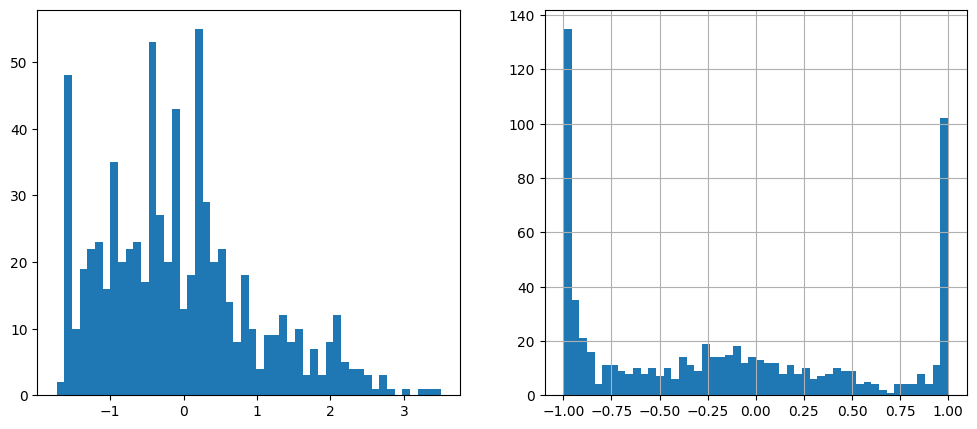

In [ ]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(nrows=1,ncols=2, figsize=(12,5))
ax[0].hist(y_test[:,0],bins=50,)
ax[1].hist(preds[:,0],bins=50)

plt.grid(True)

In [ ]:
from google.colab import drive

In [ ]:
drive.mount('content')

Mounted at content


In [ ]:
tf.saved_model.save(model, '/content/content/MyDrive/adder/model')

In [ ]:
np.savez()

In [ ]:
tf.saved_model.save(model, '/content/content/MyDrive/adder/model')